# General Notebook on fine-tuning branch point prediction using any of MultiMolecule models

Any RNA model can be selected from the [MultiMolecule](https://multimolecule.danling.org/models/) website. Simple change the `MULTIMOLECULE_MODEL` variable in the cell below, and the the two cells under the tokenizer "Load the desired model and tokenizer" section.

In [18]:
# GLOBAL VARIABLES
WORKING_DIRECTORY = '/content/drive/MyDrive/epfl_ml_project'
DATASET_PATH = 'data/fresh_dataset.txt'
MODEL_MAX_INPUT_SIZE = 1022
MULTIMOLECULE_MODEL = "rnamsm"
SAMPLE_N_DATAPOINTS = 10000 # Sample a small subset of data for testing purposes. Set to None if training on full dataset
SEED = 32

In [19]:
%%capture
!pip install datasets evaluate multimolecule==0.0.5

In [20]:
import pandas as pd
import torch
from transformers import (
#     AutoTokenizer,
#     AutoModel,
#     AutoModelForMaskedLM,
#     AutoModelForTokenClassification,
     DataCollatorForTokenClassification,
     TrainingArguments,
     Trainer
)

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [22]:
from google.colab import drive
drive.mount('/content/drive')

# Change working directory to Project folder, you may change this as needed
%cd {WORKING_DIRECTORY}

from BP_LM.scripts.data_preprocessing import *
from BP_LM.scripts.trainer_datasets_creation import *
from BP_LM.scripts.compute_metrics import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/epfl_ml_project


## Load the desired model and tokenizer

In [23]:
# Change this import depending on the model
from multimolecule import RnaTokenizer, RnaMsmForTokenPrediction, RnaMsmConfig

tokenizer = RnaTokenizer.from_pretrained(f'multimolecule/{MULTIMOLECULE_MODEL}')
# Change line below depending on what model we want
config = RnaMsmConfig()
config.problem_type = "single_label_classification"
config.num_labels = 2
model = RnaMsmForTokenPrediction.from_pretrained(f'multimolecule/{MULTIMOLECULE_MODEL}', config=config)

Some weights of RnaMsmForTokenPrediction were not initialized from the model checkpoint at multimolecule/rnamsm and are newly initialized: ['rnamsm.pooler.dense.bias', 'rnamsm.pooler.dense.weight', 'token_head.decoder.bias', 'token_head.decoder.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Set up the collator
data_collator = DataCollatorForTokenClassification(tokenizer)

## Create dataset objects for training

In [24]:
# Load dataset
df = pd.read_csv(DATASET_PATH, sep='\t')

train_dataset, val_dataset, test_dataset = create_dataset(df, tokenizer, model, MODEL_MAX_INPUT_SIZE, SEED, SAMPLE_N_DATAPOINTS)

Chromosomes in train set: {'chrX', 'chr21', 'chr6', 'chr16', 'chr22', 'chr14', 'chr15', 'chr3', 'chr19', 'chr1', 'chr2', 'chr18', 'chr20', 'chr5', 'chrY', 'chr13', 'chr7', 'chr4', 'chr17', 'chr12'}
Chromosomes in validation set: {'chr9', 'chr10'}
Chromosomes in test set: {'chr8', 'chr11'}

Total data points: 10000
Train set contains 8287 data points (82.87%)
Validation set contains 807 data points (8.07%)
Test set contains 906 data points (9.06%)


## Train model

In [27]:
# Do not save to W&B
import os
os.environ["WANDB_MODE"] = "disabled"

In [28]:
# Define model training parameters
batch_size = 4

args = TrainingArguments(
    f"multimolecule-{MULTIMOLECULE_MODEL}-finetuned-secondary-structure",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    optim = "adamw_torch",
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="F1",
    #eval_accumulation_steps = 10,
    #push_to_hub=True,
)

In [29]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [30]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

<ipython-input-31-7160a7d960c2>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Seq. acc.,Ap,Mcc,Auc,Ideal Threshold
1,0.004700,0.003604,0.526533,0.403965,0.490481,0.528418,0.735868,0.265968


TrainOutput(global_step=2072, training_loss=0.0065336943564497825, metrics={'train_runtime': 507.5072, 'train_samples_per_second': 16.329, 'train_steps_per_second': 4.083, 'total_flos': 4805427935528352.0, 'train_loss': 0.0065336943564497825, 'epoch': 1.0})

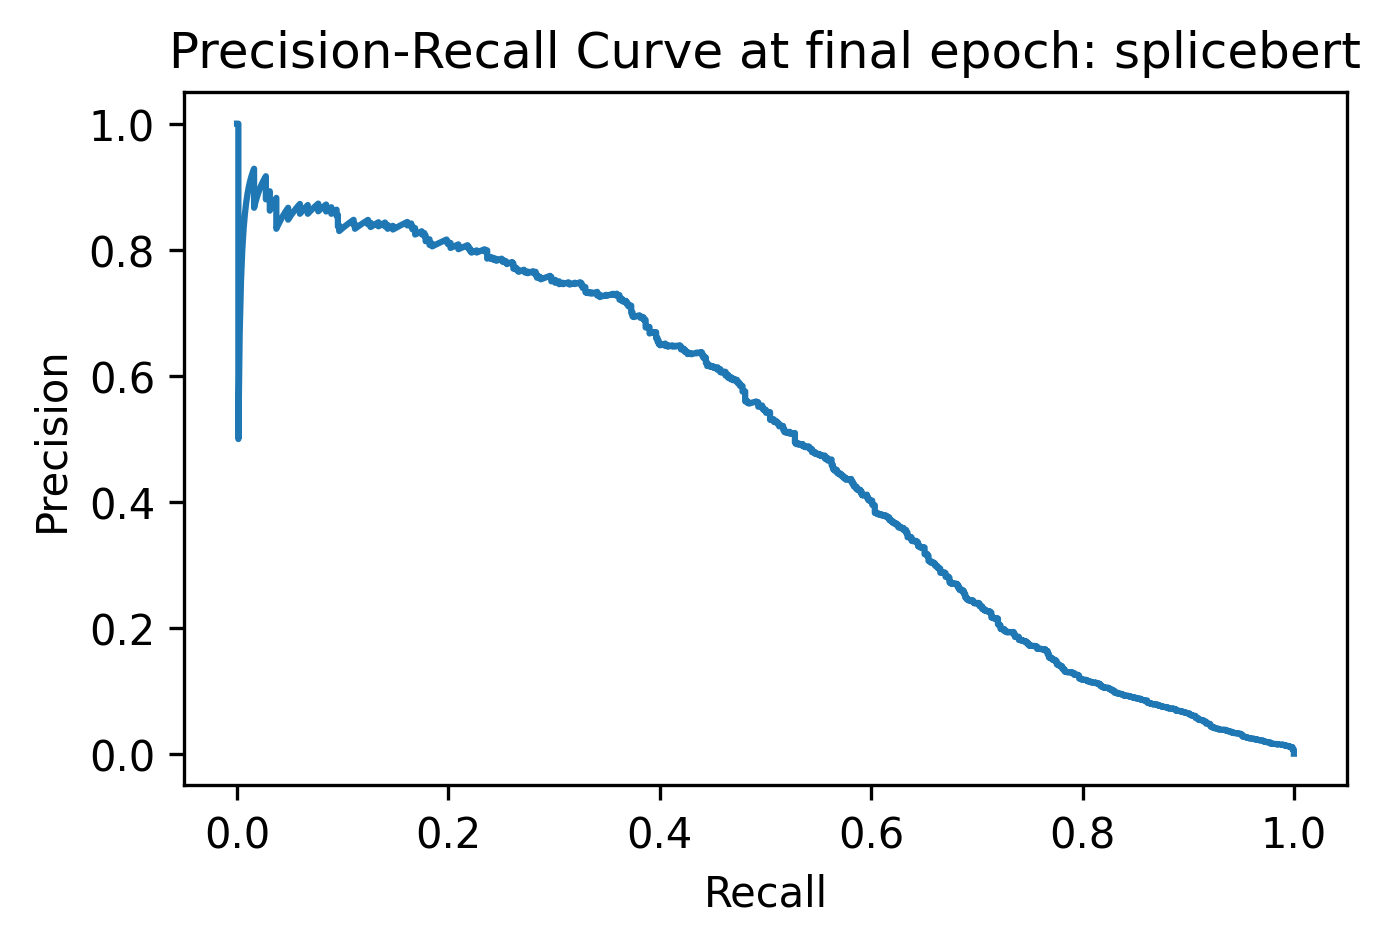

In [31]:
metrics = lambda x: compute_metrics(x, "test_metrics")
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=metrics,
    # preprocess_logits_for_metrics = preprocess_logits_for_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


## Test model's performance on test set with optimial decision boundary

In [38]:
trained_model = RnaMsmForTokenPrediction.from_pretrained(f"multimolecule-{MULTIMOLECULE_MODEL}-finetuned-secondary-structure/checkpoint-2072", config=config) #make sure you are loading the right checkpoint
tokenizer = RnaTokenizer.from_pretrained(f"multimolecule-{MULTIMOLECULE_MODEL}-finetuned-secondary-structure/checkpoint-2072")
data_collator = DataCollatorForTokenClassification(tokenizer)

<ipython-input-40-9fc462d922b9>:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tester = Trainer(


NameError: name 'F1_calc' is not defined

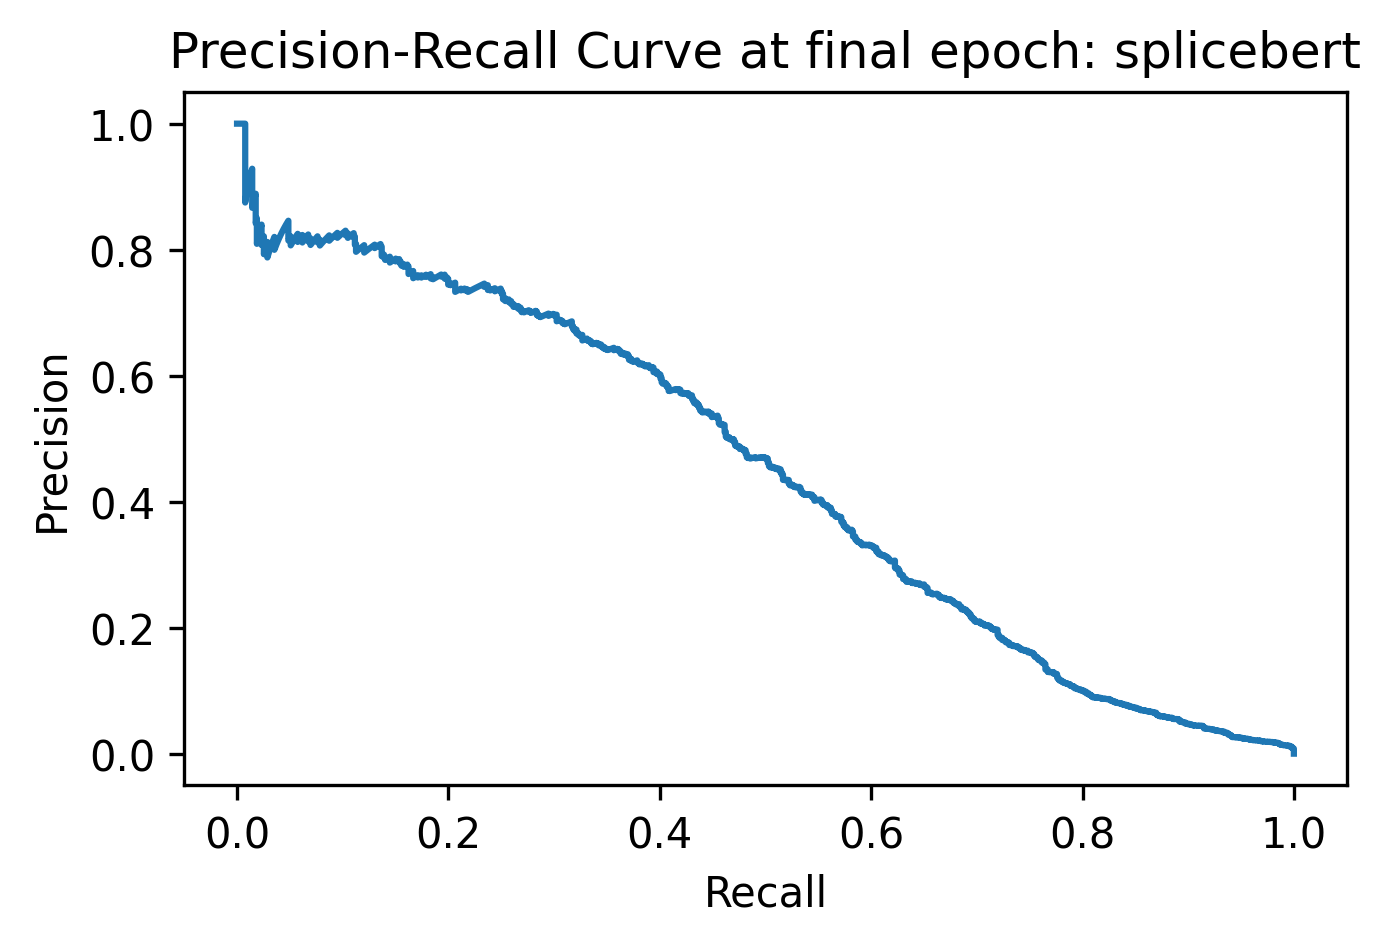

In [40]:
metric = lambda x: compute_metrics_test(x, "test_metrics", 0.265968)

testing_args = TrainingArguments(
    output_dir='/results',
    per_device_eval_batch_size=batch_size,
    do_eval=True,
    no_cuda=False,
)

tester = Trainer(
    model=trained_model,
    args=testing_args,
    eval_dataset=test_dataset,
    compute_metrics=metric,
    # preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

metrics = tester.evaluate()

print("Evaluation Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value}")